In [50]:
import math
import pickle
import copy
import gzip
import pandas as pd
import numpy as np
import random
from pymatgen.util import coord
from pymatgen.io.ase import AseAtomsAdaptor
from ase.visualize.plot import plot_atoms
from matplotlib import pyplot as plt
from pymatgen.core.structure import Structure
from pymatgen.core.periodic_table import Element
from pymatgen.core.sites import Site
from scipy.stats import maxwell

In [51]:
#You can choose the number of defects
numOfDef = 5

In [52]:
# Fucntion that prints the structure based on it's initial_structure
def printStructure(d, string):
    s0 = d.initial_structure
    d0 = list(d.defect_representation)
    ase_atoms = AseAtomsAdaptor.get_atoms(s0)
    fig, ax = plt.subplots()
    plot_atoms(ase_atoms, ax, radii=0.6, rotation=('10x, 0y, 0z'), show_unit_cell=True)
    xlim = 40
    ylim = 23
    ax.set_xlim(-2, xlim)
    ax.set_ylim(-2, ylim)
    ax.set_title(f'{string}')

In [53]:
#Function, that sets the first defect
def SettingFirstDefect(numOfDef):
    l = []
    while True:
        if numOfDef == 0:
            break
        x = np.random.randint(0, 64)
        if x in l:
            continue
        else:
            l.append(x)
            numOfDef -= 1
    return l

In [54]:
 # Counts Defect Interaction Energy based on the distance between two defects
def Defect_Interaction_Energy(x):
#     print("Расстояние = ", x)
    E = (((x * (math.cos(0.5) * ((math.cos(((0.5 * (4 * (x * (4 - x)))) / x)) * x) / x))) - x) / ((math.exp(x)) / x))
#     print("Результат = ", E)
    return E

In [141]:
#Function, that detects the probability of jump and return 1 or 0
def RandJump(energy_of_barrier, loc, scale):
    prob = 1 - maxwell.cdf(energy_of_barrier, loc, scale) 
#     print("Вероятность скачка: ", prob)
#     print (random.choices([0, 1], [1 - prob, prob]))
    return(random.choices([0, 1], [1 - prob, prob])[0])

In [92]:
def energy_of_barrier_calc(x, e, m):
    if x < 0:
            energy_of_barrier = 0.1
    else:
        energy_of_barrier = math.sqrt(2 * x * e * m)
    return energy_of_barrier

In [147]:
#Main Rand fucntion which uses funcs RandJump and Defect_Interaction_Energy
#This function equiprobably chooses where defect will go
#and then with RandJump chooses whether the event happens
#connection - словарь с ключом - рассматриваевым дефектом и значениями -
#другими дефектами, которые влияют на данный дефект
def Rand(connection):
    a = np.random.randint(0, 7)
    
    E_pot = 0.94
    e = 1.60217663 * 10 ** (-19)
    m_electon = 9.1093837 * 10 ** (-34)
    m = 1.5932871 * 10 ** (-22)
    k = 1.380649 * 10 ** (-23)
    T = 700
    
    loc = math.sqrt(2 * m * k * T)
    
    scale = math.sqrt(m * k * T)
    energy_of_interaction = 0

    
    
    x1 = list(connection.keys())[0].coords[0]
    y1 = list(connection.keys())[0].coords[1]
    x = list()
    y = list()
    for i in list(connection.values())[0]:
        x.append(i.coords[0])
        y.append(i.coords[1])
    rast = list()
        
    if a == 0:
        for i in range(len(x)):
            rast.append(math.sqrt((x1 - 1.5952 / 2 - x[i]) ** 2 + (y1 - 2.7629 / 2 - y[i]) ** 2)) # must be corrected
            energy_of_interaction += Defect_Interaction_Energy(math.sqrt((x1 - 1.5952 / 2 - x[i]) ** 2 + (y1 - 2.7629 / 2 - y[i]) ** 2))
            
            
        energy_of_barrier = energy_of_barrier_calc(E_pot + energy_of_interaction, e, m)  # It is initially an momentum to jump through the barrier
            
        if RandJump(energy_of_barrier, loc, scale) == 1:
            res = np.array([-1.5952, -2.7629, 0])
        else: res = np.array([0, 0, 0])
            
            
    elif a == 1:
        for i in range(len(x)):
            rast.append(math.sqrt((x1 - 2 * 1.5952 / 2 - x[i]) ** 2 + (y1 - y[i]) ** 2))
            energy_of_interaction += Defect_Interaction_Energy(math.sqrt((x1 - 2 * 1.5952 / 2 - x[i]) ** 2 + (y1 - y[i]) ** 2))
            
        energy_of_barrier = energy_of_barrier_calc(E_pot + energy_of_interaction, e, m)
            
        if RandJump(energy_of_barrier, loc, scale) == 1:
            res = np.array([-2 * 1.5952, 0, 0])
        else: res = np.array([0, 0, 0])
        
    elif a == 2:
        for i in range(len(x)):
            rast.append(math.sqrt((x1 - 1.5952 / 2 - x[i]) ** 2 + (y1 + 2.7629 / 2 - y[i]) ** 2))
            energy_of_interaction += Defect_Interaction_Energy(math.sqrt((x1 - 1.5952 / 2 - x[i]) ** 2 + (y1 + 2.7629 / 2 - y[i]) ** 2))
            
        energy_of_barrier = energy_of_barrier_calc(E_pot + energy_of_interaction, e, m)

        
        if RandJump(energy_of_barrier, loc, scale) == 1:
            res = np.array([-1.5952, 2.7629, 0])
        else: res = np.array([0, 0, 0])
        
    elif a == 3:
        for i in range(len(x)):
            rast.append(math.sqrt((x1 + 1.5952 / 2 - x[i]) ** 2 + (y1 + 2.7629 / 2 - y[i]) ** 2))
            energy_of_interaction += Defect_Interaction_Energy(math.sqrt((x1 + 1.5952 / 2 - x[i]) ** 2 + (y1 + 2.7629 / 2 - y[i]) ** 2))
            
        energy_of_barrier = energy_of_barrier_calc(E_pot + energy_of_interaction, e, m)

        
        if RandJump(energy_of_barrier, loc, scale) == 1:
            res = np.array([1.5952, 2.7629, 0])
        else: res = np.array([0, 0, 0])

    elif a == 4:
        for i in range(len(x)):
            rast.append(math.sqrt((x1 + 2 * 1.5952 / 2 - x[i]) ** 2 + (y1 - y[i]) ** 2))
            energy_of_interaction += Defect_Interaction_Energy(math.sqrt((x1 + 2 * 1.5952 / 2 - x[i]) ** 2 + (y1 - y[i]) ** 2))
            
        energy_of_barrier = energy_of_barrier_calc(E_pot + energy_of_interaction, e, m)
        
        if RandJump(energy_of_barrier, loc, scale) == 1:
            res = np.array([2 * 1.5952, 0, 0])
        else: res = np.array([0, 0, 0])
            
    elif a == 5:
        for i in range(len(x)):
            rast.append(math.sqrt((x1 + 1.5952 / 2 - x[i]) ** 2 + (y1 - 2.7629 / 2 - y[i]) ** 2))
            energy_of_interaction += Defect_Interaction_Energy(math.sqrt((x1 + 1.5952 / 2 - x[i]) ** 2 + (y1 - 2.7629 / 2 - y[i]) ** 2))
            
        energy_of_barrier = energy_of_barrier_calc(E_pot + energy_of_interaction, e, m)
        
        if RandJump(energy_of_barrier, loc, scale) == 1:
            res = np.array([1.5952, -2.7629, 0])
        else: res = np.array([0, 0, 0])

    elif a == 6:
        res = np.array([0, 0, 0])
        energy_of_barrier = math.sqrt(2 * E_pot * e * m)
        
        
#     print('loc = ', loc, 'energy_of_barrier = ', energy_of_barrier, 'scale = ', scale)

#     print("Барьер: ", E_pot + energy_of_interaction, '\n')
    return res

In [167]:
# Creating new structure with one defect based in function Rand() and old structure
def newDefects(olddata, numOfDef):

    
    newdata = pd.read_pickle('emptydata.pkl')
    newdata = newdata.iloc[0]
    newdata.defect_representation.clear()
    
    DefWithNoChanges = 0
    for i in range(len(list(olddata.defect_representation))):
        while True:
            connection = dict()
            connection = {olddata.defect_representation[i] : olddata.defect_representation[:i] + olddata.defect_representation[i+1:]}
#             print(connection)
            newPositionCoords = Rand(connection)
            newcoord = (olddata.defect_representation[i].coords + newPositionCoords)
            if (newcoord[0] + (newcoord[1] / 1.732) < 24) and (newcoord[0] + newcoord[1] / 1.732 > 0) and (-12 < newcoord[0] < 23) and (1 < newcoord[1] < 22):
                break
        ###
        if np.array_equal(newPositionCoords, np.array([0,0,0])):
            DefWithNoChanges += 1
        ###
        index = np.where((np.round(olddata.initial_structure.cart_coords[:,0], 1) 
                     == np.round(newcoord[0], 1))
                    & (np.round(olddata.initial_structure.cart_coords[:,1], 1) 
                     == np.round(newcoord[1], 1)))
        index = index[0][0]
        newdata.initial_structure.replace(index, Element('W'))
        newdata.defect_representation.append(newdata.initial_structure[index].species, newdata.initial_structure[index].frac_coords)

    if DefWithNoChanges == numOfDef:
        return False
    return newdata

In [198]:
#Reading the structure with no defects 
dataBegin = pd.read_pickle('emptydata.pkl')
dataBegin = dataBegin.iloc[0]
dataBegin.defect_representation.clear()

In [199]:
# Setting Randomly first defect
l = SettingFirstDefect(numOfDef)
for i in range(len(l)):
    dataBegin.initial_structure.replace(l[i], Element('W'))
    dataBegin.defect_representation.append(dataBegin.initial_structure[l[i]].species, dataBegin.initial_structure[l[i]].frac_coords)

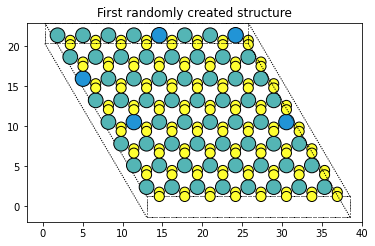

In [200]:
string = "First randomly created structure"
printStructure(dataBegin, string)

In [2]:
#Код, который помогает определить на какой итерации происходят скачки для построения диаграммы скачков
listofchanges = []

In [1]:
#Код, который помогает определить на какой итерации происходят скачки для построения диаграммы скачков
for i in range(100):
    # Creating a list of structures with defects
    datamain = pd.DataFrame()
    datamain = datamain.append(dataBegin)
    olddata = dataBegin.copy()
    string = "First structure"
    printStructure(olddata, string)
    k = 0
    for i in range(500):    
        newdata = newDefects(olddata, numOfDef)
        ### doesn't print with no new position
        if type(newdata) != bool:
            k += 1
            datamain = datamain.append(newdata)
            olddata = newdata
            string = f"The number of iteration: {k}"
            listofchanges.append(k)
    #         printStructure(newdata, string)
        else:
            k += 1


    print(listofchanges)

        ###

    #     datamain = datamain.append(newdata)
    #     olddata = newdata
    #     printStructure(newdata)

NameError: name 'pd' is not defined

<function matplotlib.pyplot.show(close=None, block=None)>

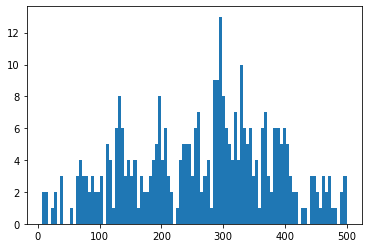

In [204]:
#Построение диаграммы скачков
import matplotlib.pyplot as plt

plt.hist(listofchanges, bins= 100)
plt.show

In [50]:
datamain

,descriptor_id,energy,energy_per_atom,fermi_level,homo,lumo,defect_representation,formation_energy,initial_structure,formation_energy_per_site,band_gap
0,6141cf15c819ca30b196b471,-1400.023811,-7.291791,-0.194139,-0.7016,1.0985,"[[11.16610508 15.65640177 3.719751 ] W, [-4....",0.166689,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.166689,1.8001
0,6141cf15c819ca30b196b471,-1400.023811,-7.291791,-0.194139,-0.7016,1.0985,"[[11.16610508 15.65640177 3.719751 ] W, [-4....",0.166689,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.166689,1.8001
0,6141cf15c819ca30b196b471,-1400.023811,-7.291791,-0.194139,-0.7016,1.0985,"[[ 9.57094723 18.41929621 3.719751 ] W, [-4....",0.166689,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.166689,1.8001
0,6141cf15c819ca30b196b471,-1400.023811,-7.291791,-0.194139,-0.7016,1.0985,"[[ 9.57094723 18.41929621 3.719751 ] W, [-4....",0.166689,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.166689,1.8001
0,6141cf15c819ca30b196b471,-1400.023811,-7.291791,-0.194139,-0.7016,1.0985,"[[ 9.57094723 18.41929621 3.719751 ] W, [-4....",0.166689,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.166689,1.8001
...,...,...,...,...,...,...,...,...,...,...,...
0,6141cf15c819ca30b196b471,-1400.023811,-7.291791,-0.194139,-0.7016,1.0985,"[[-6.38063127 18.41929621 3.719751 ] W, [-6....",0.166689,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.166689,1.8001
0,6141cf15c819ca30b196b471,-1400.023811,-7.291791,-0.194139,-0.7016,1.0985,"[[-6.38063127 18.41929621 3.719751 ] W, [-7....",0.166689,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.166689,1.8001
0,6141cf15c819ca30b196b471,-1400.023811,-7.291791,-0.194139,-0.7016,1.0985,"[[-6.38063127 18.41929621 3.719751 ] W, [-7....",0.166689,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.166689,1.8001
0,6141cf15c819ca30b196b471,-1400.023811,-7.291791,-0.194139,-0.7016,1.0985,"[[-4.78547342 15.65640177 3.719751 ] W, [-7....",0.166689,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.166689,1.8001
